# Introduction
**Todo:** Paragraph(s)

# MP3 & AAC Codecs
**Todo:** A paragraph for history of MP3 and AAC codecs

As can be seen in the flow chart below, MP3 and AAC codecs use some similar steps to generate compressed audio and similar steps to decode the compressed bitstream back to audio PCM signal. These similar steps are: Modified Discrete Cosine Transform (MDCT), Scaling, Quantization, and [Huffman Coding](https://en.wikipedia.org/wiki/Huffman_coding). Therefore, we will be focusing more on those three and specially MDCT as the last two are well known in almost every compression scheme including zip or gz. Among differences of MP3 and AAC codecs, it can be seen that MP3 codec is using [Polyphase Quadrature Filter (PQF)](https://en.wikipedia.org/wiki/Polyphase_quadrature_filter) before the MDCT, and [Alias Reduction](https://en.wikipedia.org/wiki/Aliasing) after the MDCT. Contrarily, AAC codec is using [Temporal Noise Shaping (TNS)](https://en.wikipedia.org/wiki/Noise_shaping) and [Perceptual 
Noise Substitution (PNS)](https://ccrma.stanford.edu/~kapilkm/422/Audio%20Compression%20using%20Entropy%20Coding%20and%20PNS-1.pdf).

![MP3 and AAC Encoders and Decoders](./images/mp3aac.svg)

To analyze the outcome of these two codecs, two sample wave files are prepared. One is a music instrument and the other is a vocal speech. They will be encoded to a compressed file with similar bitrates (128k) and they will be decoded back (regenerated) to a wave file again. Afterwards we will try to identify the lost information using spectograms.

To do the file conversion, we can use FFmpeg. FFmpeg is a cross-platform software containing many audio and video codecs that can be used for conversions which can be attained from [here](https://ffmpeg.org/). To convert the piano wave file to MP3 format, we can use the command below:

In [1]:
!ffmpeg -y -i audio/piano.wav -b:a 128k audio/piano.mp3                        2> /dev/null

Similarly, to convert the piano wave file to AAC format, we can use the command below. Notice that it is best to specify the audio codec.

In [2]:
!ffmpeg -y -i audio/piano.wav -b:a 128k audio/piano.aac        2> /dev/null

To convert compressed audio files back to wave formats, we can use the following commands below:

In [3]:
!ffmpeg -y -i audio/piano.mp3 audio/piano_regenerated_mp3.wav      2> /dev/null
!ffmpeg -y -i audio/piano.aac audio/piano_regenerated_aac.wav      2> /dev/null

To analyze the regenerated wave files, we use the following three techniques:

1. **Compression ratio** which is the most common metric of compression. It can be calculated using the code below:

In [4]:
import os

def calc_ratio(original_file, other_file):
    original_file_size = os.path.getsize(original_file)
    other_file_size = os.path.getsize(other_file)
    return round(other_file_size*100/original_file_size, 2)

2. **Audio spectograms** using the `matplotlib` module. Spectograms can show us amplitude of different frequencies per every moment of a wave file. It is useful to see what frequencies are modified by the codec. It can be drawn using the code below:

In [5]:
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio
from ipywidgets import widgets, Layout

def wave_specgram(wav_file, titles, duration=None):    
    data, rate = sf.read(wav_file)
    if duration:
        data = data[:rate*duration]    
    if len(titles) > 1: titles.insert(1,"")
    plt.title("\n".join(titles))
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.specgram(data, Fs=rate)
    
    widget = widgets.Output()
    with widget:
        display(Audio(wav_file))
    return widget

3. **Perceptual Evaluation of Audio Quality (PEAQ)** which is a standardized algorithm used for objective measurements of perceived audio quality, and is based on generally accepted psychoacoustic principles. The overall goal of this algorithm is to obtain a quality measure similar to a Subjective Difference Grade (SDG) acquired from listening tests with human participants. This output is called the [Objective Difference Grade (ODG)](https://en.wikipedia.org/wiki/Objective_difference_grade). The ODG ranges from 0 to −4 and is defined as follows: 
    
         0 = Imperceptible
        -1 = Perceptible, but not annoying
        -2 = Slightly annoying
        -3 = Annoying
        -4 = Very annoying 
        
    Sadly, a complete implementation of PEAQ couldn't be found on the internet, so Kabal's Matlab implementation of algorithm (provided in [Stephen Welch and Matthew Cohen's Github repository](https://github.com/stephencwelch/Perceptual-Coding-In-Python)) is used outside of this notebook and results are provided for you.
    
    When running the PEAQ algorithm, one important thing to remember is that the audio shouldn't be shifted. Some audio codecs, specifically AAC, apply some paddings in their calculations. For our case, I noticed that there is 1024 sample padding in the regenerated wave files from AAC codecs. So I use the following code to shift them back and run the PEAQ algorithm on it.

In [6]:
import numpy as np

def shift_wave(src_wav_file, dst_wav_file, shift_amount):
    data, rate = sf.read(src_wav_file)
    data = np.roll(data, shift_amount)
    sf.write(file=dst_wav_file, data=data, samplerate=rate)

With the code below, raw piano wave file is compared to the regenerated wave file from MP3 and AAC compressions. Each one of them contain spectogram, the ratio, and the calculated ODG.

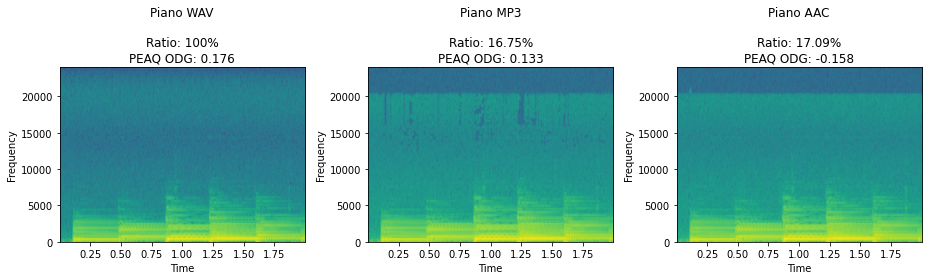

In [7]:
plt.figure(figsize=(13,4))
plt.subplot(1, 3, 1)
w1 = wave_specgram("audio/piano.wav", ["Piano WAV", "Ratio: 100%", "PEAQ ODG: 0.176"], duration=2)

plt.subplot(1, 3, 2)
ratio = calc_ratio('audio/piano.wav','audio/piano.mp3')
w2 = wave_specgram("audio/piano_regenerated_mp3.wav", ["Piano MP3", f"Ratio: {ratio}%", "PEAQ ODG: 0.133"], duration=2)

plt.subplot(1, 3, 3)
ratio = calc_ratio('audio/piano.wav','audio/piano.aac')
shift_wave("audio/piano_regenerated_aac.wav", "audio/piano_regenerated_aac_shifted.wav", -1024)
w3 = wave_specgram("audio/piano_regenerated_aac_shifted.wav", ["Piano AAC", f"Ratio: {ratio}%", "PEAQ ODG: -0.158"], duration=2)

plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox([w1, w2, w3], layout=box_layout)

**Todo:** A paragraph describing what can be seen in the piano spectogram.

Now let's do the same for the speech sample and observe the changes after the MP3 and AAC compressions. First, we will compress and then decompress it using FFmpeg, then we will show the spectogram, compression ratio, and the calculated ODG.

In [8]:
!ffmpeg -y -i audio/voice.wav -b:a 128k audio/voice.mp3         2> /dev/null
!ffmpeg -y -i audio/voice.wav -b:a 128k audio/voice.aac         2> /dev/null
!ffmpeg -y -i audio/voice.mp3 audio/voice_regenerated_mp3.wav   2> /dev/null
!ffmpeg -y -i audio/voice.aac audio/voice_regenerated_aac.wav   2> /dev/null

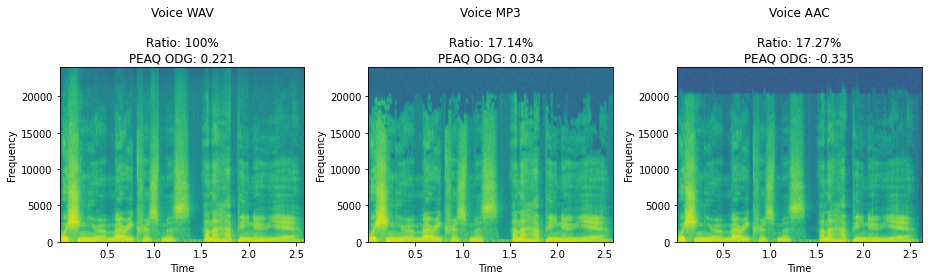

In [9]:
plt.figure(figsize=(13,4))
plt.subplot(1, 3, 1)
w1 = wave_specgram("audio/voice.wav", ["Voice WAV", "Ratio: 100%","PEAQ ODG: 0.221"])

plt.subplot(1, 3, 2)
ratio = calc_ratio('audio/voice.wav','audio/voice.mp3')
w2 = wave_specgram("audio/voice_regenerated_mp3.wav", ["Voice MP3", f"Ratio: {ratio}%", "PEAQ ODG: 0.034"])

plt.subplot(1, 3, 3)
ratio = calc_ratio('audio/voice.wav','audio/voice.aac')
shift_wave("audio/voice_regenerated_aac.wav", "audio/voice_regenerated_aac_shifted.wav", -1024)
w3 = wave_specgram("audio/voice_regenerated_aac_shifted.wav", ["Voice AAC", f"Ratio: {ratio}%", "PEAQ ODG: -0.335"])

plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox([w1, w2, w3], layout=box_layout)

**Todo:** A paragraph describing what can be seen in the piano spectogram.

# Fourier Transform
**Todo:** A paragraph as a reminder of Fourier series, Fourier transform, and discrete cosine transform: 

\begin{aligned} s_{\scriptscriptstyle N}(x)={\frac {A_{0}}{2}}+\sum _{n=1}^{N}A_{n}\cdot \cos \left({\tfrac {2\pi }{P}}nx-\varphi _{n}\right).\end{aligned}

The animation below shows an example of fourier transformation:
![](https://upload.wikimedia.org/wikipedia/commons/2/2b/Fourier_series_and_transform.gif)

The animation below shows the convergence of equation with increment of N value:
![](https://upload.wikimedia.org/wikipedia/commons/3/37/Example_of_Fourier_Convergence.gif)

# MDCT
**Todo:** A paragraph about the Modified Discrete Cosine Transform (MDCT). 

\begin{aligned} X_{k}=\sum _{{n=0}}^{{2N-1}}x_{n}\cos \left[{\frac  {\pi }{N}}\left(n+{\frac  {1}{2}}+{\frac  {N}{2}}\right)\left(k+{\frac  {1}{2}}\right)\right].\end{aligned}

Wikipedia says: a transform based on the type-IV discrete cosine transform (DCT-IV), with the additional property of being lapped: it is designed to be performed on consecutive blocks of a larger dataset, where subsequent blocks are overlapped so that the last half of one block coincides with the first half of the next block. This overlapping, in addition to the energy-compaction qualities of the DCT, makes the MDCT especially attractive for signal compression applications, since it helps to avoid artifacts stemming from the block boundaries. As a result of these advantages, the MDCT is the most widely used lossy compression technique in audio data compression. It is employed in most modern audio coding standards, including MP3, Dolby Digital (AC-3), Vorbis (Ogg), Windows Media Audio (WMA), ATRAC, Cook, Advanced Audio Coding (AAC), High-Definition Coding (HDC), LDAC, Dolby AC-4, and MPEG-H 3D Audio, as well as speech coding standards such as AAC-LD (LD-MDCT), G.722.1, G.729.1, CELT, and Opus.

**Todo:** A paragraph about practically trying MDCT using artificial signals, starting with a constant signal.

In [10]:
import mdct
import matplotlib.pyplot as plt

def generate_mdct_const(rate, duration, output_wav_file):
    data = np.zeros((512, rate*duration//512),dtype=np.float64)    
    data[15,:] = 1000
    return data

**Todo:** Short description about a sine signal.

In [11]:
def generate_mdct_sine(rate, duration, output_wav_file):
    data = np.zeros((512, rate*duration//512),dtype=np.float64)
    for i in range(data.shape[1]):
        data[int(30 + 20*np.sin(np.deg2rad(5*i))),i] = 1000
    return data
  

**Todo:** Short description about drawing the MDCT spectogram.

In [12]:
def draw_mdct_spectogram(data, rate, duration, title):
    data = data[:,:rate*duration//512]
    data = np.float64(data)
    eps = 1e-10
    data = np.log(eps + data ** 2)
    data = np.flipud(data)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency Index')
    plt.imshow(data, aspect='auto', extent=[0,duration,0,512])     

Now let's put it together.

/home/matin/Projects/LossyAudioCompressionTutorial/venv/lib64/python3.10/site-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/home/matin/Projects/LossyAudioCompressionTutorial/venv/lib64/python3.10/site-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]


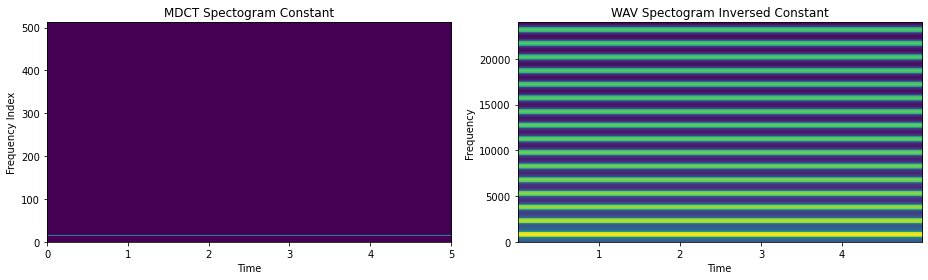

Output()

In [13]:
plt.figure(figsize=(13,4))
data = generate_mdct_const(48000, 5, "audio/mdct_const.wav")
plt.subplot(1, 2, 1)
draw_mdct_spectogram(data, 48000, 5, "MDCT Spectogram Constant")

sig2 = mdct.imdct(data)
sf.write("audio/mdct_const.wav", sig2, 48000)
plt.subplot(1, 2, 2)
a = wave_specgram("audio/mdct_const.wav", ['WAV Spectogram Inversed Constant'])

plt.tight_layout()
plt.show()
display(a)

**Todo:** A paragraph describing what is observabale in the spectogram above.

/home/matin/Projects/LossyAudioCompressionTutorial/venv/lib64/python3.10/site-packages/matplotlib/axes/_axes.py:7580: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


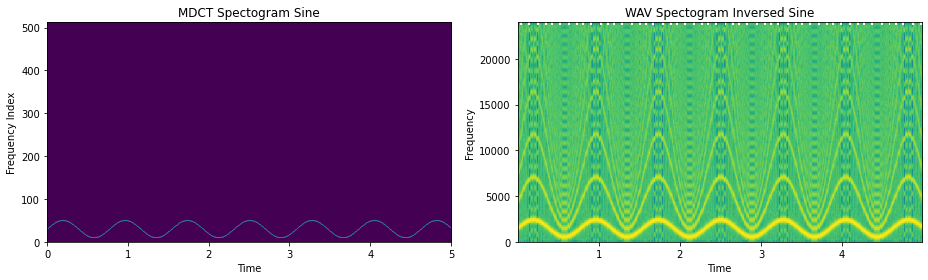

Output()

In [14]:
plt.figure(figsize=(13,4))
data = generate_mdct_sine(48000, 5, "audio/mdct_sine.wav")
plt.subplot(1, 2, 1)
draw_mdct_spectogram(data, 48000, 5, "MDCT Spectogram Sine")

sig2 = mdct.imdct(data)
sf.write("audio/mdct_sine.wav", sig2, 48000)
plt.subplot(1, 2, 2)
a = wave_specgram("audio/mdct_sine.wav", ['WAV Spectogram Inversed Sine'])

plt.tight_layout()
plt.show()
display(a)

**Todo:** A paragraph describing what is observabale in the spectogram above.

# Encoder
**Big To do:** Paragraphs describing how to make a compression. Need to describe each step: 1) High Freq Cut, 2) Float16, 3) Rounding Floats, 4) Removing Low Intensities, 5) using numpy's savez_compressed which already has scaling and huffman coding inside it.

In [15]:
import soundfile as sf

encoding_stages = []

def encode(input_wav_file, output_npz_name):

    steps_count = 5
    global encoding_stages
    encoding_stages.clear()
    
    def encode_write(data, step_number, step_name):        
        encoding_stages.append(step_name)
        output_file = f'{output_npz_name}{step_number}.npz'    
        np.savez_compressed(output_file, rate=rate, data=data)
        plt.subplot(1, steps_count, step_number+1)
        ratio = calc_ratio(input_wav_file,output_file)
        draw_mdct_spectogram(data, rate, 2, f'{step_name}\n\nRatio: {ratio}%')
    
    data, rate = sf.read(input_wav_file)
    plt.figure(figsize=(13,4))    
    
    r = mdct.mdct(data)
    encode_write(r, step_number=0, step_name='Float64')    
    
    r = np.float16(r)
    encode_write(r, step_number=1, step_name='Float16')

    r[256:, :] = 0    
    encode_write(r, step_number=2, step_name='High Freq Cut')    

    r = np.round(r, decimals=3)
    encode_write(r, step_number=3, step_name='Round Floats')   

    r = np.where(abs(r) < 0.01, 0, r)
    encode_write(r, step_number=4, step_name='Remove Low Intensities')    
    
    plt.tight_layout()
    plt.show()

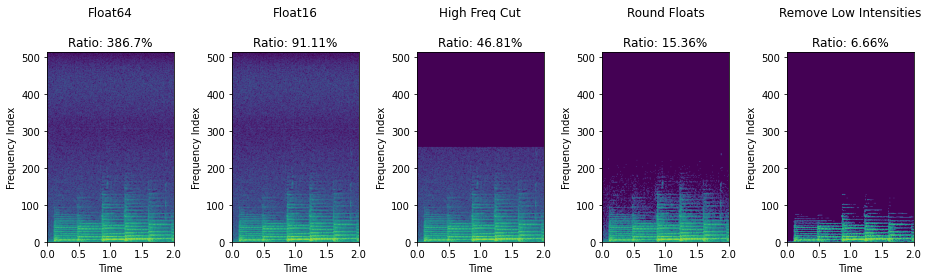

In [16]:
encode('audio/piano.wav', 'audio/piano_npz')

**Todo:** Describe what is observable in the spectograms above.

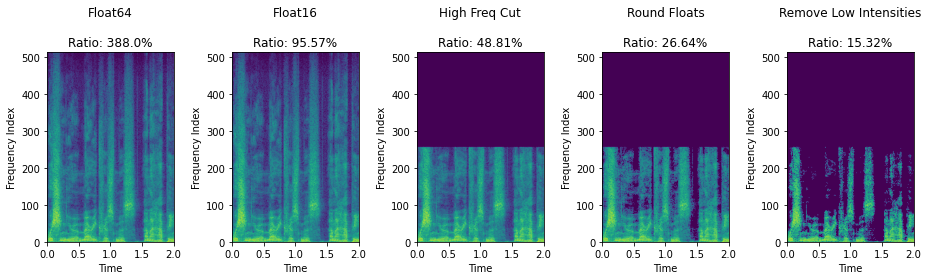

In [17]:
encode('audio/voice.wav', 'audio/voice_npz')

**Todo:** Describe what is observable in the spectograms above.

# Decoder

**Todo:** A paragraph about the decoder.

In [18]:
def decode(input_npz_file, output_wav_file):
    npz = np.load(input_npz_file)
    rate = npz['rate']
    sig2 = mdct.imdct(npz['data'])
    sf.write(output_wav_file, sig2, rate)

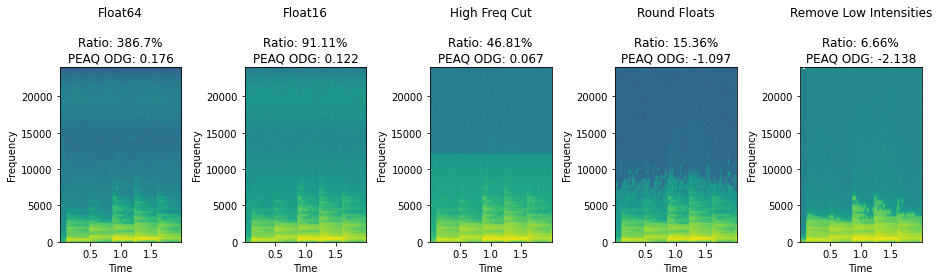

In [19]:
plt.figure(figsize=(13,4))
audio_widgets = []

odg = [0.176, 0.122, 0.067, -1.097, -2.138]

for i in range(len(encoding_stages)):
    plt.subplot(1, len(encoding_stages), i+1)
    decode(f'audio/piano_npz{i}.npz', f'audio/piano_regenerated_npz{i}.wav')
    ratio = calc_ratio('audio/piano.wav',f'audio/piano_npz{i}.npz')
    widget = wave_specgram(f'audio/piano_regenerated_npz{i}.wav', [encoding_stages[i], f"Ratio: {ratio}%", f"PEAQ ODG: {odg[i]}"], duration=2)
    audio_widgets.append(widget)
    
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox(audio_widgets, layout=box_layout)

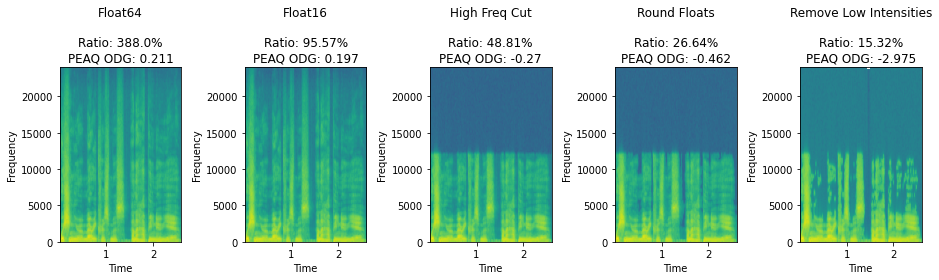

In [20]:
plt.figure(figsize=(13,4))
audio_widgets = []

odg = [0.211, 0.197, -0.270, -0.462, -2.975]

for i in range(len(encoding_stages)):
    plt.subplot(1, len(encoding_stages), i+1)
    decode(f'audio/voice_npz{i}.npz', f'audio/voice_regenerated_npz{i}.wav')
    ratio = calc_ratio('audio/voice.wav',f'audio/voice_npz{i}.npz')
    widget = wave_specgram(f'audio/voice_regenerated_npz{i}.wav', [encoding_stages[i],f"Ratio: {ratio}%", f"PEAQ ODG: {odg[i]}"])
    audio_widgets.append(widget)
    
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox(audio_widgets, layout=box_layout)

**Todo:** Describe what is observable in the spectograms above.
# Conclusion
**Todo:** Some paragraphs here.

# References (10-20)

Ravelli, Emmanuel, Gal Richard, and Laurent Daudet. “Union of MDCT Bases for Audio Coding.” IEEE Transactions on Audio, Speech, and Language Processing 16, no. 8 (November 2008): 1361–72. https://doi.org/10.1109/TASL.2008.2004290.

Ravelli, Emmanuel, Gaël Richard, and Laurent Daudet. “Audio Signal Representations for Indexing in the Transform Domain.” IEEE Transactions on Audio, Speech, and Language Processing 18, no. 3 (March 2010): 434–46. https://doi.org/10.1109/TASL.2009.2025099.

P. Kabal, "An Examination and Interpretation of ITU-R BS.1387: Perceptual Evaluation of Audio Quality", TSP Lab Technical Report, Dept. Electrical & Computer Engineering, McGill University, May 2002. 


**To Read:**

Stephen. Perceptual Coding In Python. Matlab, 2021. https://github.com/stephencwelch/Perceptual-Coding-In-Python/blob/2993f57570663768c02745019185091a23f021fe/PEAQ.md.

“MUSHRA.” In Wikipedia, March 26, 2021. https://en.wikipedia.org/w/index.php?title=MUSHRA&oldid=1014261385.

“Karlheinz Brandenburg.” Accessed November 18, 2021. https://scholar.google.de/citations?user=a9nMg8sAAAAJ&hl=de.

To read what is coming up and what needs are next steps in audio compression schemes.

https://github.com/gtzan/mir_program_kadenze/blob/master/course1/session3/kadenze_mir_c1_s3_4_monophonic_pitch_estimation.ipynb